# Introduction
This is part 1 of the [Data Journalism Workflow tutorial  series](https://www.kaggle.com/iamleonie/data-journalism-workflow).
In this notebook you will learn how to clean and process the data before you begin with any exploration or visualizations.

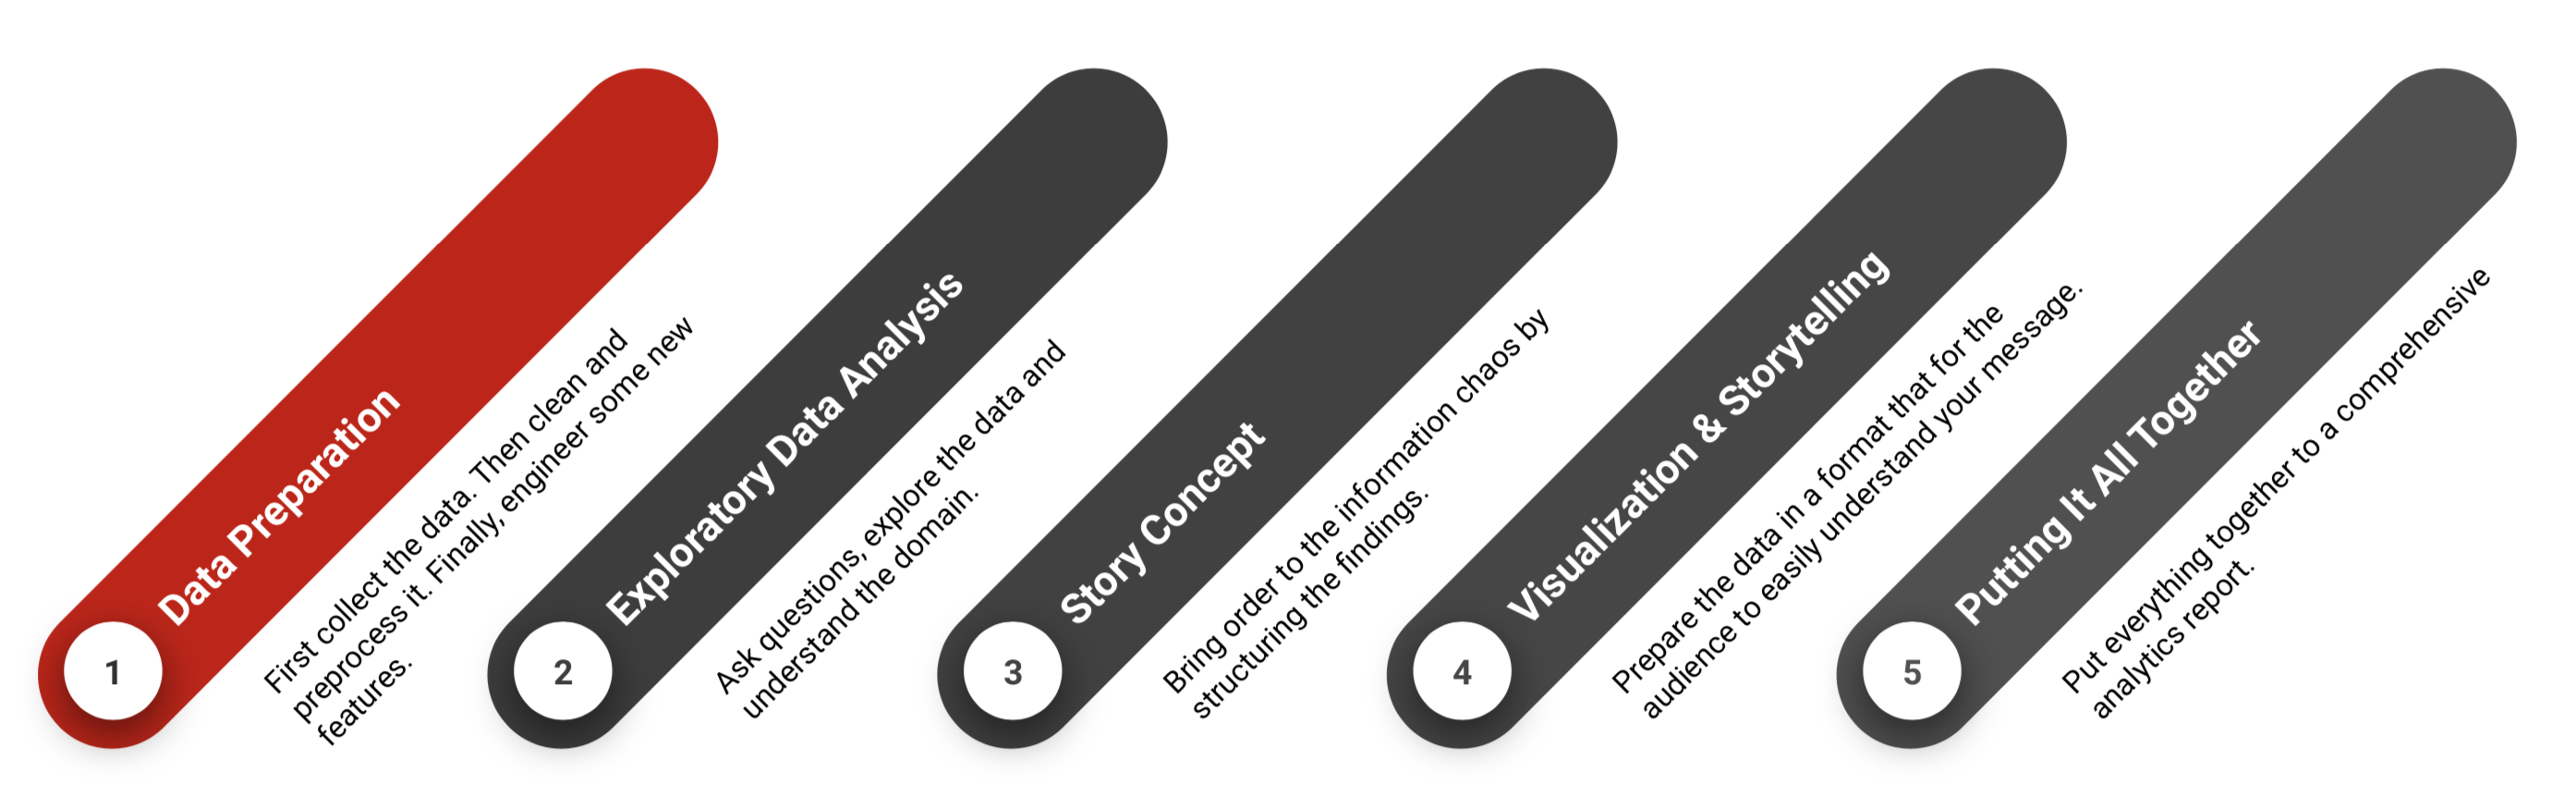

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from time import strptime
from datetime import datetime, date 

import re

from sklearn.preprocessing import MultiLabelBinarizer

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer

import spacy # Leading library for NLP
nlp = spacy.load('en')
from nltk.stem import SnowballStemmer #WordNetLemmatizer, 
import string

# Data Collection

I guess this is the "Chicken or the Egg" problem of data journalism. Do you **start with a question/hypothesis or do you just dive into any dataset** that looks interesting to you? This is probably a whole topic on its own and since I am not a professional data journalist, I do not feel qualified to give a good answer to this question. But my guess would be that if you have a specific question in mind that you would like to answer, it could help you focus your attention during the exploration. (If you are a data journalist, please feel free to share your thoughts on this topic in the comments.) Additionally, **gathering the data** can be another topic on its own. 

For the sake of this tutorial, we will just take a fun dataset, dive in and see what stories the data is going to tell us. We will be using the popular [Netflix Movies and TV Shows](https://www.kaggle.com/shivamb/netflix-shows) dataset by [Shivam Bansal](https://www.kaggle.com/shivamb) as a starting point. Therefore, the data collection step in this case is only to load the data. However, it is important to understand how the data was collected even if the dataset is already prepared for you.

In the dataset description, we can see that
> [t]his dataset consists of **tv shows and movies available on Netflix as of 2019**. The dataset is **collected from Flixable** which is a third-party Netflix search engine. 

Furthermore, if you go to the 'Metadata' tab, you can see that this dataset is was **created in December 2019** and has since been **updated four times**. The last update was in January 2021.
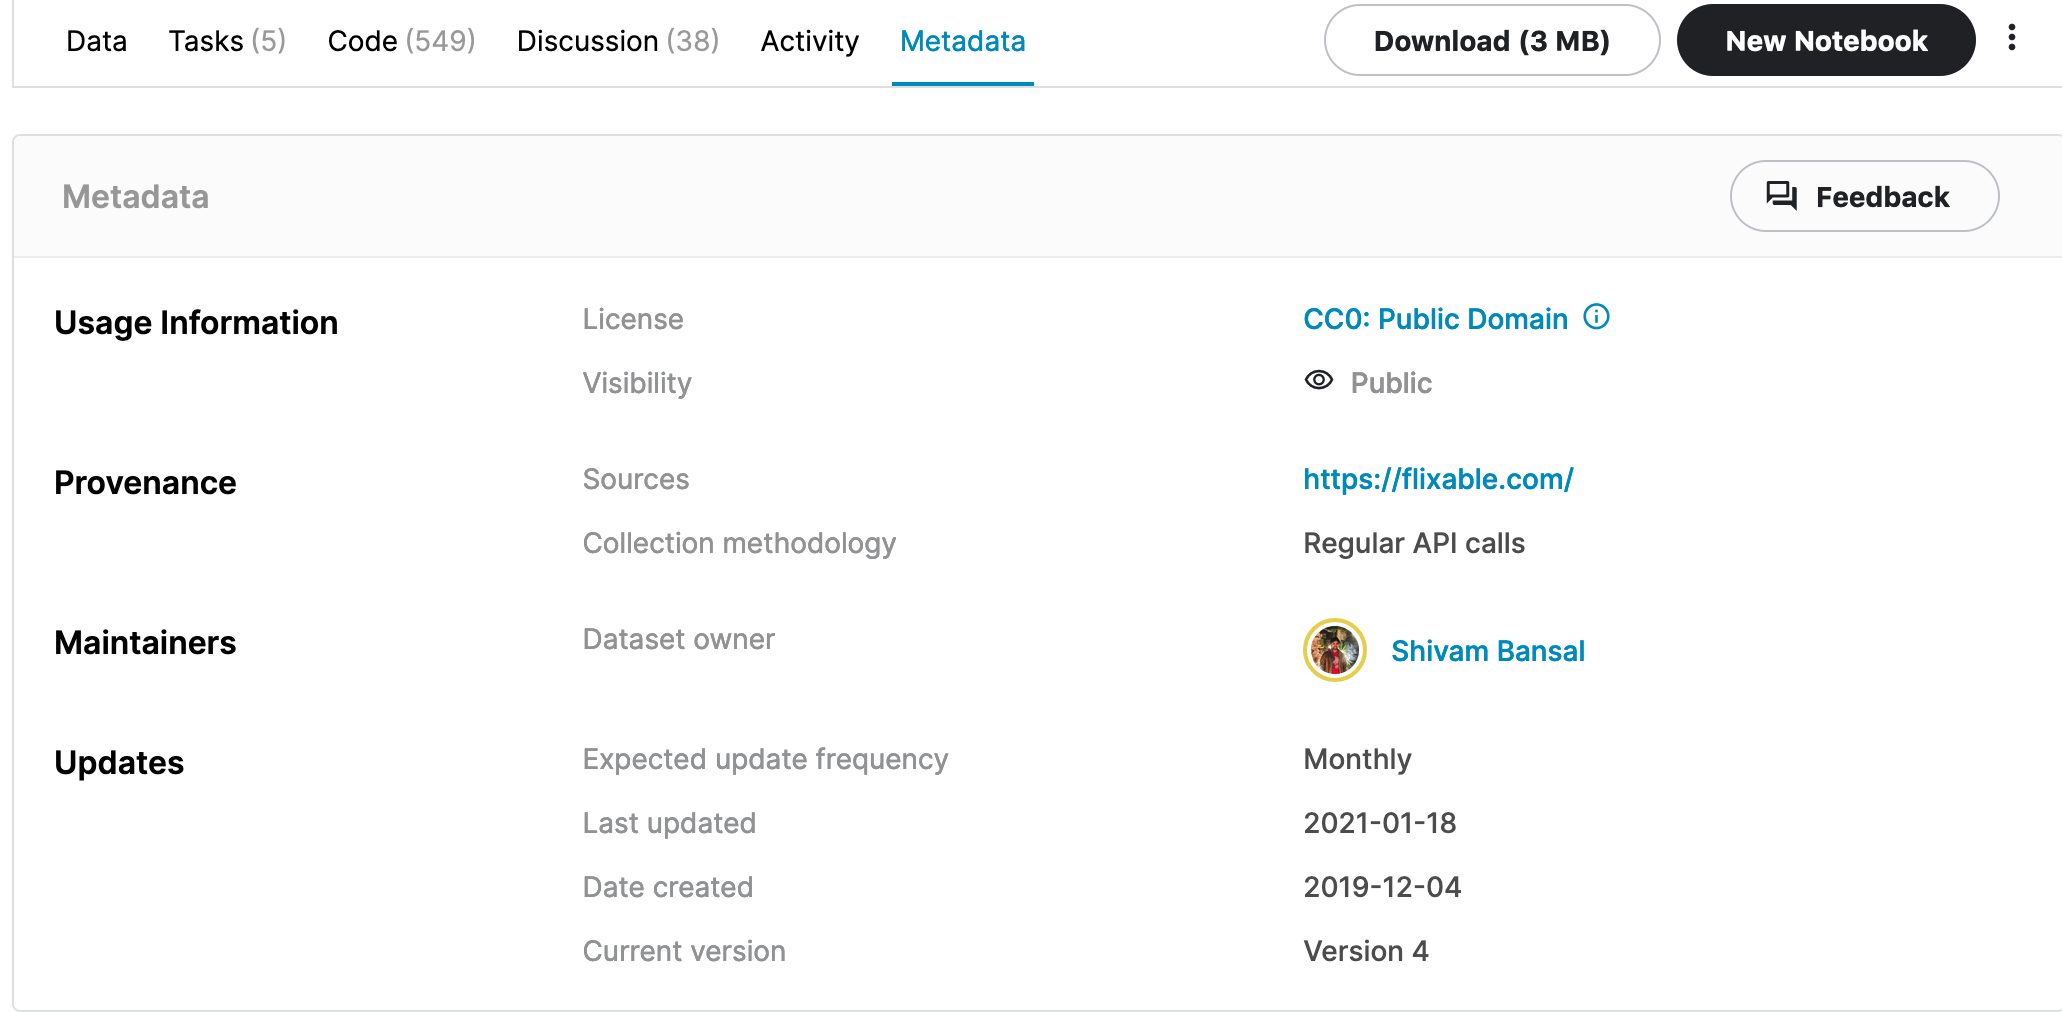

Since we didn't prepare a question we would like to answer beforehand, we will just explore the data. To simplify the dataset a little bit for the purpose of this tutorial, we will **focus only on Netflix TV shows** and ignore Netflix movies for now.

The dataset has 12 columns, such as the title of the TV show, its director and cast, and so on, as shown below.

In [ ]:
# Load the dataset
netflix_titles = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')

# Only filter for TV shows
netflix_shows = netflix_titles[(netflix_titles.type == 'TV Show')].reset_index(drop=True)

del netflix_titles
netflix_shows.head()

# Data Cleaning & Preprocessing
Before we begin with the actual data analysis, we should do a little bit of data cleaning and some preprocessing of the data. According to The Guardian [2], they spend about 70% of their time on data cleaning and preprocessing and only 30% on the fun part of visualization.

Let's get a quick overview of the state of the data and make a rough plan of what we have to do. We will check the data types (`.info()`), number of unique values (`.nunique()`), and number of missing values (`.isna()`) for each column as shown below.

In [ ]:
netflix_shows.info()

In [ ]:
netflix_shows.nunique()

In [ ]:
netflix_shows.isna().sum(axis=0)

After the above checks, we already found a few cleaning steps to do:
* **Remove unnecessary columns**
    * `show_id` does not contain any relevant information and should be removed
    * `type` only has one unique value ("TV Shows") since we removed all movies. Therefore, this column does not contain any relevant information and should be removed
* **Handling missing values**<br>
    We have to think about how to handle the missing values in the columns `director`, `cast`, `country`, `date_added`, and `rating`
* **Correct data format** <br>
    `date_added` and `duration` are currently of the data type object and should be converted to a datetime type and numerical type respectively
* **Untangle merged columns** <br>
    Additionally, from the first look at the dataframe we can see that `cast` and `listed_in` have names and categories that can appear in mutliple data points. We should think about how to preprocess this for easier handling.
* **Handle Text Data**

## Remove Unnecessary Columns
`show_id` does not contain any relevant information and should be removed. Also, `type` only has one unique value ("TV Shows") since we removed all movies. Therefore, this column does not contain any relevant information and should be removed.

In [ ]:
# Remove unnecessary columns
netflix_shows.drop(["show_id", "type"], axis=1, inplace=True)

## Handling missing values

We have to think about how to handle the missing values in the columns `director`, `cast`, `country`, `date_added`, and `rating`.
* For `director`, `cast`, `country`, we cann fill the missing values with "Unknown" since these are categorical features.
* The missing values in `date_added` will be filled with "January 1, 1800", which will be our dummy date.
* The `rating` columns rating already has a categoriy "NR", which means "no rating". We will used this category to fill missing values.

## Correct Data Format
`date_added` and `duration` are currently of the data type object and should be converted to a datetime type and numerical type respectively.

In [ ]:
display(netflix_shows[['duration', 'date_added']].head().style.set_caption("Before correcting data format"))

# Convert duration from string format to integer and re
# Remove keyword "season"
netflix_shows["duration"] = netflix_shows.duration.apply(lambda x: x.split(' ')[0])
# Convert to integer
netflix_shows["duration"] = netflix_shows["duration"].astype(int)


# Split the date format into year, month, day
# Convert to string
netflix_shows.date_added = netflix_shows.date_added.astype(str)
# Clean data where first character in string is a space
netflix_shows.date_added = netflix_shows.date_added.apply(lambda x: x[1:] if x[0] == " " else x)

# Get the month
netflix_shows['date_added_month'] = netflix_shows.date_added.apply(lambda x: x.split(" ")[0])
# Convert string to integer
netflix_shows['date_added_month'] = netflix_shows.date_added_month.apply(lambda x: strptime(x,'%B').tm_mon if ((x != "")&(x != "nan")) else np.nan)
# Fill nan and convert to integer
netflix_shows['date_added_month'] = netflix_shows['date_added_month'].fillna(1).astype(int)

# Get the day
netflix_shows['date_added_day'] = netflix_shows.date_added.apply(lambda x: x.split(" ")[1] if len(x.split(" ")) > 1 else np.nan)
# Remove ","
netflix_shows['date_added_day'] = netflix_shows.date_added_day.apply(lambda x: x.split(",")[0] if x==x else np.nan)
# Fill nan and convert to integer
netflix_shows['date_added_day'] = netflix_shows['date_added_day'].fillna(1).astype(int)

# Get the year
netflix_shows['date_added_year'] = netflix_shows.date_added.apply(lambda x: x.split(" ")[2] if len(x.split(" ")) > 2 else np.nan)
# Fill nan and convert to integer
netflix_shows['date_added_year'] = netflix_shows['date_added_year'].fillna(1800).astype(int)

# Convert date_added to datetime format
netflix_shows['date_added'] = netflix_shows.apply(lambda x: datetime(x.date_added_year, x.date_added_month, x.date_added_day), axis=1)

display(netflix_shows[['duration', 'date_added', 'date_added_day', 'date_added_month', 'date_added_year']].head().style.set_caption("After correcting data format"))

## Untangle Merged Columns
Additionally, from the first look at the dataframe we can see that `cast` and `listed_in` have names and categories that can appear in mutliple data points. We should think about how to preprocess this for easier handling.

With the help of the `MultiLabelBinarizer`, we can easily untangle these merged values.

In [ ]:
display(netflix_shows[['listed_in']].head().style.set_caption("Before using MultiLabelBinarizer"))

mlb_columns = ["listed_in", "cast", "director", "country"]
mlb = MultiLabelBinarizer()

for col in mlb_columns:
    netflix_shows[col] = netflix_shows[col].fillna("Unknown")
    netflix_shows[col] = netflix_shows[col].apply(lambda x: x.split(", "))
    netflix_shows = netflix_shows.join(pd.DataFrame(mlb.fit_transform(netflix_shows[col]),columns= [f"{col}_{re.sub(' ', '', c)}" for c in mlb.classes_]))

netflix_shows.drop(mlb_columns, axis=1, inplace=True)

display(netflix_shows[netflix_shows.columns[netflix_shows.columns.str.startswith('listed_in')]].head().style.set_caption("After using MultiLabelBinarizer"))


## Handle Text Data
Text to Document-Term Matrix

In [ ]:
display(netflix_shows[['description']].head().style.set_table_attributes("style='display:inline'").set_caption("Before creating Document-Term Matrix"))


def clean_text(text):
    # Convert text to lowercase
    text = text.lower() 

    # Remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)

    # Remove non-Roman characters
    text = re.sub("([^\x00-\x7F])+", " ", text)
    
    # Tokenize
    text = nlp(text)

    stemmer = SnowballStemmer("english")

    text_clean = ""
    for token in text:
        # Remove stop words and remove words with fewer than 3 chars
        if (not token.is_stop) and len(token) > 3:
            # Lemmatize and tokenize
            text_clean += stemmer.stem(token.lemma_) + " "
    
    return text_clean


netflix_shows['description_clean'] = netflix_shows.description.apply(lambda x: clean_text(x))

cv = CountVectorizer(ngram_range=(1,1)) # Doesn't include bigrams
data_cv = cv.fit_transform(netflix_shows['description_clean'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns = cv.get_feature_names())
data_dtm.index = netflix_shows.index
data_dtm.columns = [f"dtm_descr_{c}" for c in data_dtm.columns]

netflix_shows = netflix_shows.join(data_dtm)

cv = CountVectorizer(ngram_range=(1,1)) # Doesn't include bigrams
data_cv = cv.fit_transform(netflix_shows['title'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns = cv.get_feature_names())
data_dtm.index = netflix_shows.index
data_dtm.columns = [f"dtm_title_{c}" for c in data_dtm.columns]

netflix_shows = netflix_shows.join(data_dtm)

display(netflix_shows[netflix_shows.columns[netflix_shows.columns.str.startswith('dtm_descr_')]].head().style.set_caption("After creating Document-Term Matrix"))


# Feature Engineering
Now that we have cleaned the data, it is time to create some additional features. Feature engineering can help you gain a better understanding of your dataset, similarly to how new features can improve your performance when you are trying to model data. To keep things simple, we will only create three new features.

In [ ]:
# The weekday on which the TV show was added to the library
netflix_shows['date_added_weekday'] = pd.DatetimeIndex(netflix_shows['date_added']).weekday

# The release year of the first season of the TV show
netflix_shows['first_release_year'] = netflix_shows.release_year - netflix_shows.duration

# The time between the original release of the TV show and the TV show being added to the Netflix library
netflix_shows['time_first_release_to_netflix'] = netflix_shows.date_added_year - netflix_shows.first_release_year

## 🚀 Let's continue with [Lesson 2: Exploratory Data Analysis](https://www.kaggle.com/iamleonie/data-journalism-exploratory-data-analysis-2-5)

In [ ]:
# Save current state to output
netflix_shows.to_csv("netflix_shows.csv", index=False)